In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Mai 30

@author: yaning
"""

import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)
import pickle
path = "/home/yaning/Documents/"

2026-01-01 22:59:20.230148: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-01 22:59:20.232999: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-01 22:59:20.240297: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767304760.252042   37003 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767304760.255542   37003 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767304760.266047   37003 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [9]:
# (x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
# x_train = x_train.astype(np.float32) / 255.0
# x_test = x_test.astype(np.float32) / 255.0
# x_train = np.expand_dims(x_train, -1)
# x_test = np.expand_dims(x_test, -1)

# # x_train = x_train[200:300]
# # y_train = y_train[200:300]

dict = {'imgs': x, 'tag': y}

with open("datasets/mnst_30_200_5.pkl", "wb") as f:
    pickle.dump(dict, f)

In [3]:
x_train.shape

(60000, 28, 28, 1)

In [4]:
# get 0,3 and 5 numbers only
tag_list = []
pix_list = []
for i in range(y_train.shape[0]):
    temp = y_train[i]
    if temp == 5:
        tag_list.append(temp)
        pix_list.append(x_train[i])

In [5]:
len(tag_list)

5421

In [6]:
# take first 200 of them 
# pix_list = pix_list[-100:]
# tag_list = tag_list[-100:]
pix_list = pix_list[:200]
tag_list = tag_list[:200]

In [7]:
tag_list = np.array(tag_list)
pix_list = np.array(pix_list)

In [5]:
with open("datasets/mnst_30_second.pkl", "rb") as f:
    imgs = pickle.load(f)

In [6]:
x = imgs["imgs"]
y = imgs["tag"]

In [8]:
x = pix_list
y = tag_list

In [11]:
x.shape

(100, 28, 28, 1)

In [11]:
y.shape

(100,)

In [24]:
y

array([0, 3, 0, 3, 0, 5, 0, 3, 5, 5, 5, 5, 3, 0, 0, 5, 0, 3, 0, 3, 5, 0,
       3, 0, 3, 0, 3, 5, 0, 5, 3, 5, 0, 3, 0, 3, 3, 3, 0, 0, 5, 0, 3, 5,
       0, 3, 5, 3, 3, 5, 5, 3, 3, 0, 5, 0, 5, 0, 3, 5, 0, 0, 3, 0, 5, 3,
       3, 5, 3, 0, 0, 3, 5, 0, 3, 0, 3, 5, 0, 3, 0, 0, 0, 5, 5, 0, 3, 5,
       3, 5, 3, 3, 5, 0, 3, 3, 0, 5, 3, 5], dtype=uint8)

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

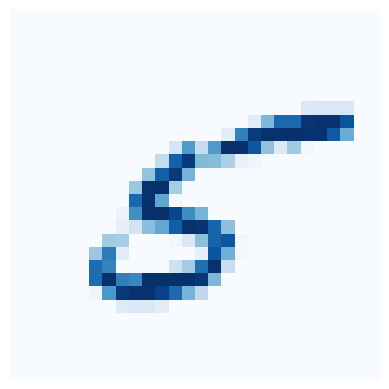

In [10]:
plt.imshow(x[12,:,:,:], cmap='Blues')
plt.axis('off')  # optional: removes axes
# plt.savefig("7.png", bbox_inches='tight', pad_inches=0)


normalise them independently and also keep the 0/pure-black ones zeros

if not the zeros will be around 0.5 after normalisation but there should be no information at all

In [11]:
# only normalise non-zero ones 
def normalise_non_zero(feature_maps):
    data_norm = np.zeros_like(feature_maps)
    for i in range(feature_maps.shape[0]):
        img = feature_maps[i]
        non_zero_mask = img != 0
        img = img[non_zero_mask]
        img_min = img.min()
        img_max = img.max()
        if img_max > img_min:
            data_norm[i][non_zero_mask] = (img - img_min) / (img_max - img_min)
        else:
            data_norm[i] = 0
    return data_norm

# normalise everything
def normalise(feature_maps):
    data_norm = np.zeros_like(feature_maps)
    for i in range(feature_maps.shape[0]):
        img = feature_maps[i]
        img_min = img.min()
        img_max = img.max()
        if img_max > img_min:
            data_norm[i] = (img - img_min) / (img_max - img_min)
        else:
            data_norm[i] = 0
    return data_norm

In [12]:
# size=7, sigma=2.0, Lambda=3.0, psi=0, gamma=0.5, theta=0
def gabor_kernel(size=4, sigma=4.0, Lambda=10.0, psi=0.5, gamma=1, theta=0):
    """Generate a 2D Gabor filter kernel."""
    half = size // 2
    y, x = np.meshgrid(range(-half, half+1), range(-half, half+1))
    x_theta = x * np.cos(theta) + y * np.sin(theta) + 1
    y_theta = -x * np.sin(theta) + y * np.cos(theta)
    gb = np.exp(-0.5 * (x_theta**2 + (gamma**2) * y_theta**2) / (sigma**2)) * np.cos(2 * np.pi * x_theta / Lambda + psi)
    return gb

# Generate 6 filters rotated from 0 to 360
angles = np.deg2rad(np.arange(0, 360, 45))
filters = np.stack([gabor_kernel(theta=angle) for angle in angles], axis=-1)  # shape (size, size, 6)

# Conv2D weights shape: (kernel_h, kernel_w, input_channels, output_channels)
filters = filters[:, :, np.newaxis, :]  # add input channel dim = 1

# Normalize filters to zero mean and unit norm (optional)
filters -= filters.mean(axis=(0,1), keepdims=True)
filters /= np.linalg.norm(filters, axis=(0,1), keepdims=True) + 1e-10

In [9]:
filters.shape

(5, 5, 1, 8)

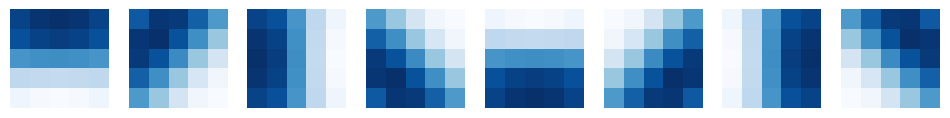

In [27]:
plt.figure(figsize=(12,3))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(filters[:,:,0, i], cmap='Blues')
    # plt.title(f"{int(np.rad2deg(angles[i]))}° response")
    plt.axis('off')


plt.savefig("filters.png", bbox_inches='tight', pad_inches=0)
plt.show()

In [13]:
gabor_data = []
for pic in x:
    img = np.expand_dims(pic, axis=0)
    feature_maps = tf.nn.conv2d(img, filters, strides=3, padding='SAME')
    gabor_data.append(feature_maps[0])

E0000 00:00:1767304831.498681   37003 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
E0000 00:00:1767304831.501152   37003 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1767304831.513412   37003 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [14]:
gabor_data = np.array(gabor_data)

In [15]:
gabor_data.shape

(200, 10, 10, 8)

In [16]:
normalised_gabor_data = normalise_non_zero(gabor_data)

In [17]:
normalised_gabor_data.shape

(200, 10, 10, 8)

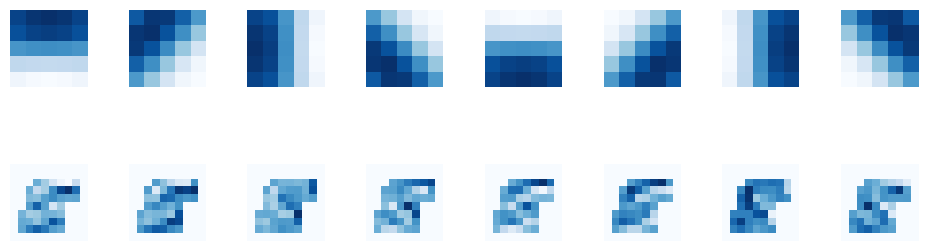

In [20]:
plt.figure(figsize=(12,3))
for i in range(8):
    plt.subplot(2,8,i+1)
    plt.imshow(filters[:,:,0, i], cmap='Blues')
    plt.axis('off')

    plt.subplot(2,8,i+9)
    plt.imshow(normalised_gabor_data[15,:,:,i], cmap='Blues')
    # plt.title(f"{int(np.rad2deg(angles[i]))}° response")
    plt.axis('off')

plt.subplots_adjust(hspace=1.) 

plt.savefig("both.png", bbox_inches='tight', pad_inches=0)
plt.show()

In [21]:
normalised_gabor_data = np.where(normalised_gabor_data > 0.5, 1, 0)

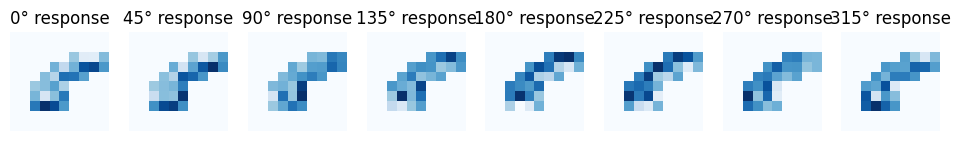

In [18]:


plt.figure(figsize=(12,3))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(normalised_gabor_data[1,:,:,i], cmap='Blues')
    plt.title(f"{int(np.rad2deg(angles[i]))}° response")
    plt.axis('off')
plt.show()

In [19]:
with open(path + "Spiking_add_files/gabor_data_mnst_200_5_nonbi.pkl", "wb") as f:
    pickle.dump(normalised_gabor_data, f)

In [24]:
# form an shape (5000, 3) array with 5000 time points and 3 input neurons
# every fire is 45-50 cycles, 
pointCount = 6000
start_tstep = 500
one_cycle = np.concatenate((np.ones(45, dtype=bool), np.zeros(189, dtype=bool)))
# one_cycle = np.ones(234)
firing_duration = 45+189
# 23*(45+189) = 5382
total_time = 5382


non_fire_array = np.zeros(pointCount, dtype=bool)

fire_seq = np.tile(one_cycle, 23)
fire_array = non_fire_array.copy()
fire_array[start_tstep:start_tstep+len(fire_seq)] = fire_seq

In [25]:
normalised_gabor_data.shape

(100, 10, 10, 8)

In [26]:
fire_data = np.zeros((100,10,10,8, 4000), dtype=bool)
for i in range(normalised_gabor_data.shape[0]):
    for x in range(normalised_gabor_data.shape[1]):
        for y in range(normalised_gabor_data.shape[2]):
            for z in range(normalised_gabor_data.shape[3]):
                if normalised_gabor_data[i,x,y,z] == 0:
                    fire_data[i,x,y,z] = non_fire_array[:4000]
                else:
                    fire_data[i,x,y,z] = fire_array[:4000]

In [29]:
fire_data.shape

(100, 10, 10, 8, 4000)

In [55]:
for i in range(y.shape[0]):
    if y[i] == 7:
        print(i)

8
12
22


In [33]:
chosen_fire_data = fire_data[21]

In [25]:
chosen_fire_data = np.concatenate([chosen_fire_data] * 4, axis=-1)

In [34]:
chosen_fire_data.shape

(10, 10, 8, 4000)

In [35]:
p = 0.01
mask = np.random.rand(*chosen_fire_data.shape) < p
b_chosen_fire_data = chosen_fire_data | mask

In [33]:
with open(path + "fire_data_mnst_all_hunni_200-300.pkl", "wb") as f:
    pickle.dump(fire_data, f)